In [5]:
%env OUTPUT_PATH=/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples
%env DATA_SOURCE=/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset

env: OUTPUT_PATH=/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples
env: DATA_SOURCE=/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset


2022-03-25 16:34:10,265:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Images/OK/
2022-03-25 16:34:10,268:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Images/NG/
2022-03-25 16:34:10,270:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Masks/OK/
2022-03-25 16:34:10,271:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Masks/NG/
2022-03-25 16:34:16,750:root:INFO - Loading classifier pipeline from /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples


No. of training examples: 822
No. of training examples: 24
No. of validation examples: 23
No. of test examples: 775


2022-03-25 16:34:41,795:root:INFO - Training classifier and saving it locally


Epoch 1/50
1/1 [==============================] - 13s 13s/step - loss: 0.0035 - accuracy: 0.3831 - val_loss: 1.2960 - val_accuracy: 0.1724
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.0025 - accuracy: 0.1551 - val_loss: 1.5215 - val_accuracy: 0.0419
Epoch 3/50
1/1 [==============================] - 5s 5s/step - loss: 0.0022 - accuracy: 0.0438 - val_loss: 1.6760 - val_accuracy: 0.0230
Epoch 4/50
1/1 [==============================] - 4s 4s/step - loss: 0.0022 - accuracy: 0.0221 - val_loss: 1.7309 - val_accuracy: 0.0177
Epoch 5/50
1/1 [==============================] - 5s 5s/step - loss: 0.0022 - accuracy: 0.0177 - val_loss: 1.6998 - val_accuracy: 0.0197
Epoch 6/50
1/1 [==============================] - 5s 5s/step - loss: 0.0021 - accuracy: 0.0192 - val_loss: 1.6043 - val_accuracy: 0.0268
Epoch 7/50
1/1 [==============================] - 6s 6s/step - loss: 0.0020 - accuracy: 0.0275 - val_loss: 1.4630 - val_accuracy: 0.0443
Epoch 8/50
1/1 [=======================

2022-03-25 16:38:40,948:root:INFO - Writing tokenizer into /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples


INFO:tensorflow:Assets written to: ram://7eef73ac-dce6-4526-9119-dd719d820121/assets


2022-03-25 16:39:24,452:tensorflow:INFO - Assets written to: ram://7eef73ac-dce6-4526-9119-dd719d820121/assets


1/1 [==============================] - 2s 2s/step - loss: 0.0094 - accuracy: 0.9983


2022-03-25 16:39:29,234:root:INFO - -----START INFERENCE-----


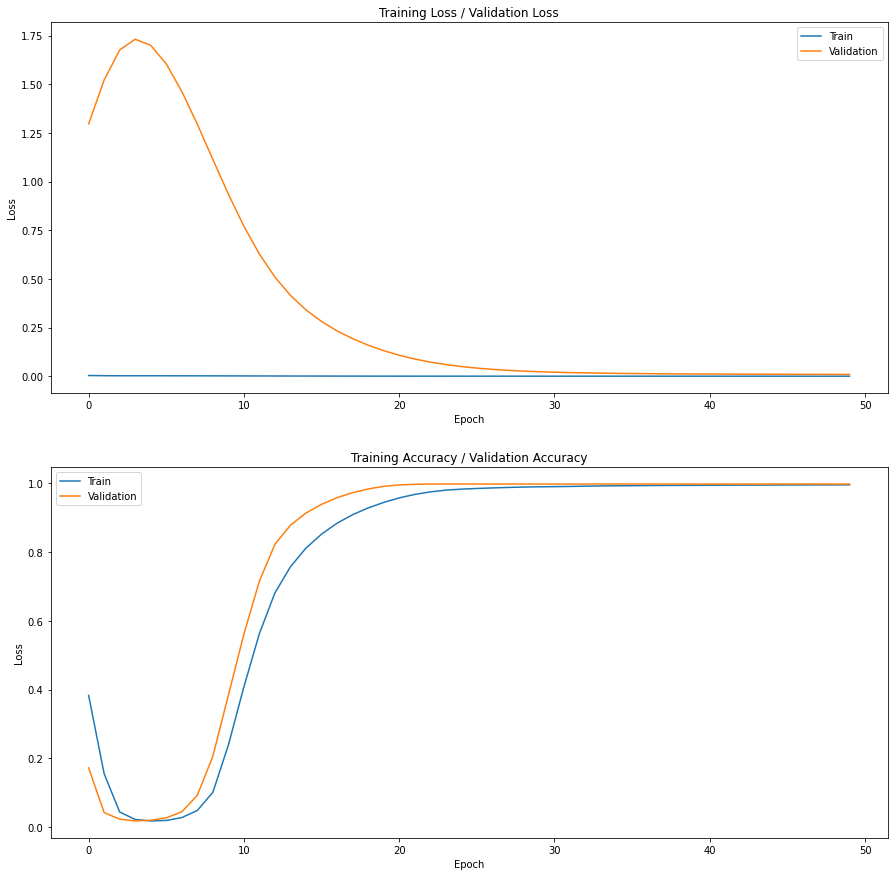

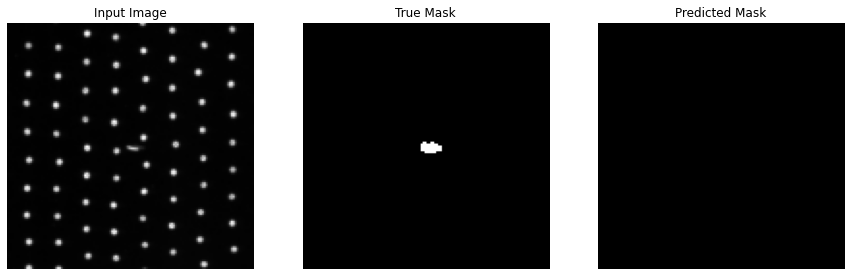

2022-03-25 16:39:33,222:root:INFO - -----END INFERENCE-----


In [46]:
# -*- coding: utf-8 -*-
"""
Training script to showcase the end-to-end training and evaluation script.
"""

import numpy as np
import pandas as pd
#import datetime
import logging
import cv2
import joblib
import os
import keras
import ast

#from sapai import tracking
from os.path import exists
from joblib import load, dump
from os import makedirs
from os import environ
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow_datasets
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt


FORMAT = "%(asctime)s:%(name)s:%(levelname)s - %(message)s"
# Use filename="file.log" as a param to logging to log to a file
logging.basicConfig(format=FORMAT, level=logging.INFO)


class TrainSKInterface:
    def __init__(self) -> None:
        # Set the params for the training below
        self.image_pipeline = None
        self.dataset_all = None
        self.train, self.val, self.test = None, None, None
        self.dataset_name = "lgp_dataset"
        self.model_name = "segmentation_model.pkl"
        self.output_path = environ["OUTPUT_PATH"]
        self.file_name = environ["DATA_SOURCE"]
        self.loss = None
        self.val_loss = None
        self.accuracy = None
        self.val_accuracy = None
        self.IMG_WIDTH = 128
        self.IMG_HEIGHT = 128
        self.target_classes = None
        self.training_metrics = None


    def create_dataset(self, img_folder, bnw, binary):
        img_data_array = []
        color_str = cv2.IMREAD_COLOR
        color_int = 3
        if(bnw):
            color_str = cv2.cv2.IMREAD_GRAYSCALE
            color_int = 1
        for file in sorted(os.listdir(img_folder)):
            image_path = os.path.join(img_folder, file)
            image = cv2.imread(image_path, color_str)
            image = cv2.resize(image, (self.IMG_HEIGHT, self.IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255
            image = np.reshape(image, (self.IMG_WIDTH,self.IMG_HEIGHT,color_int))
            if(bnw):
                image = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)[1]
            if(binary):
                image = image.tobytes()
            img_data_array.append(image)
        return img_data_array
    

    def read_dataset(self) -> None:
        """
        Reads the images file from path
        """
        
        path_img_ok = self.file_name + "/Images/OK/"
        path_img_ko = self.file_name + "/Images/NG/"
        path_msk_ok = self.file_name + "/Masks/OK/"
        path_msk_ko = self.file_name + "/Masks/NG/"
        
        logging.info(f"{path_img_ok}")
        logging.info(f"{path_img_ko}")
        logging.info(f"{path_msk_ok}")
        logging.info(f"{path_msk_ko}")
        
        img_dataset_ok_bin = self.create_dataset(path_img_ok, False, True)
        img_dataset_ko_bin = self.create_dataset(path_img_ko, False, True)
        msk_dataset_ok_bin = self.create_dataset(path_msk_ok, True, True)
        msk_dataset_ko_bin = self.create_dataset(path_msk_ko, True, True)

        df_img_dataset_ok = pd.DataFrame(columns = ['image','label'])
        df_img_dataset_ok['image'] = img_dataset_ok_bin
        df_img_dataset_ok['label'] = 0
        df_img_dataset_ko = pd.DataFrame(columns = ['image','label'])
        df_img_dataset_ko['image'] = img_dataset_ko_bin
        df_img_dataset_ko['label'] = 1
        
        df_msk_dataset_ok = pd.DataFrame(columns = ['mask'])
        df_msk_dataset_ok['mask'] = msk_dataset_ok_bin
        df_msk_dataset_ko = pd.DataFrame(columns = ['mask'])
        df_msk_dataset_ko['mask'] = msk_dataset_ko_bin

        df_img_dataset_tot = pd.concat([df_img_dataset_ok,df_img_dataset_ko], ignore_index=True)
        df_msk_dataset_tot = pd.concat([df_msk_dataset_ok,df_msk_dataset_ko], ignore_index=True)
        
        self.dataset_all = pd.merge(df_img_dataset_tot, df_msk_dataset_tot, left_index=True, right_index=True)
        self.dataset_all = self.dataset_all.sample(frac=1).reset_index(drop=True)
        print(f"No. of training examples: {self.dataset_all.shape[0]}")
        
        return None


    def split_dataset(self) -> None:
        """
        Split the dataset into train, validate and test

        Raises:
            Error: if dataset_train and dataset_test are not set
        """
        if self.dataset_all is None:
            raise Exception("Train or test data not set")

        #Change splitting proportions
        self.train, self.val = train_test_split(self.dataset_all, test_size=0.97, random_state=25)
        self.val, self.test = train_test_split(self.val, test_size=0.97, random_state=25)

        print(f"No. of training examples: {self.train.shape[0]}")
        print(f"No. of validation examples: {self.val.shape[0]}")
        print(f"No. of test examples: {self.test.shape[0]}")

        return None


    def convert_back(self, df, category, color_int):
        temp_arr = []
        for i in df[category].values:
            a = np.frombuffer(i, dtype=np.float32)
            a = a.reshape(self.IMG_WIDTH,self.IMG_HEIGHT,color_int)
            temp_arr.append(a)
            #print(a.shape)
        return temp_arr

    
    def unet_model(self, output_channels:int, down_stack, up_stack):
        inputs = tf.keras.layers.Input(shape=[128, 128, 3])

        # Downsampling through the model
        skips = down_stack(inputs)
        x = skips[-1]
        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])

        # This is the last layer of the model
        last = tf.keras.layers.Conv2DTranspose(
            filters=output_channels, kernel_size=3, strides=2,
            padding='same')  #64x64 -> 128x128

        x = last(x)

        return tf.keras.Model(inputs=inputs, outputs=x)
    

    def prepare_model(self):
        base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

        # Use the activations of these layers
        layer_names = [
            'block_1_expand_relu',   # 64x64
            'block_3_expand_relu',   # 32x32
            'block_6_expand_relu',   # 16x16
            'block_13_expand_relu',  # 8x8
            'block_16_project',      # 4x4
        ]
        base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

        # Create the feature extraction model
        down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
        down_stack.trainable = False

        up_stack = [
            pix2pix.upsample(512, 3),  # 4x4 -> 8x8
            pix2pix.upsample(256, 3),  # 8x8 -> 16x16
            pix2pix.upsample(128, 3),  # 16x16 -> 32x32
            pix2pix.upsample(64, 3),   # 32x32 -> 64x64
        ]
        
        OUTPUT_CLASSES = 2
        self.image_pipeline = self.unet_model(output_channels=OUTPUT_CLASSES, 
                                              down_stack=down_stack, up_stack=up_stack)
        self.image_pipeline.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

        return None


    def train_model(self) -> None:
        """
        Train and save the model
        """
        
        #print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
        #config = tf.compat.v1.ConfigProto(device_count = {'GPU': 0, 'CPU': 8}) 
        #sess = tf.compat.v1.Session(config=config) 
        #keras.backend.set_session(sess)
        
        img_train = self.convert_back(self.train, 'image', 3)
        img_val = self.convert_back(self.val, 'image', 3)
        msk_train = self.convert_back(self.train, 'mask', 1)
        msk_val = self.convert_back(self.val, 'mask', 1)
        
        class_weights = tf.constant([1.0, 1000.0])
        class_weights = class_weights/tf.reduce_sum(class_weights)
        sample_weights = tf.gather(class_weights, indices=tf.cast(msk_train, tf.int32))

        history = self.image_pipeline.fit(
            x=np.array(img_train, np.float32) 
            ,y=np.array(msk_train, np.float32)
            ,epochs=50 #Change to higher number
            #,steps_per_epoch=STEPS_PER_EPOCH
            #,validation_steps=VALIDATION_STEPS
            ,validation_data=(np.array(img_val, np.float32), np.array(msk_val, np.float32))
            ,sample_weight=np.array(sample_weights, np.float32)
        )
        
        self.loss = history.history['loss']
        self.val_loss = history.history['val_loss']
        self.accuracy = history.history['accuracy']
        self.val_accuracy = history.history['val_accuracy']

        return None


    def save_model(self) -> None:
        """
        Saves the model to the local path
        """
        
        logging.info(f"Writing tokenizer into {self.output_path}")
        if not exists(self.output_path):
            makedirs(self.output_path)
        # Save the Tokenizer to pickle file
        with open(f"{self.output_path}/{self.model_name}", "wb") as handle:
            dump([self.image_pipeline, self.target_classes], handle)

        return None


    def get_model(self) -> None:
        """
        Get the model if it is available locally
        """
        
        if exists(f"{self.output_path}/{self.model_name}"):
            logging.info(f"Loading classifier pipeline from {self.output_path}")
            with open(f"{self.output_path}/{self.model_name}", "rb") as handle:
                [self.image_pipeline, self.target_classes] = load(handle)

        else:
            logging.info(f"Model has not been trained yet!")

        return None


    def model_metrics(self):
        """
        Perform an inference on the model that was trained
        """
        if self.image_pipeline is None:
            self.get_model()

        infer_data = np.array(self.convert_back(self.val, 'image', 3), np.float32) #Change to test
        infer_masks = np.array(self.convert_back(self.val, 'mask', 1), np.float32) #Change to test
        
        score = self.image_pipeline.evaluate(infer_data, infer_masks)
        #print("Accuracy: " + str(score[0]))

        metric = [
            {"name": "Model accuracy",
            "value": float(score[1]),
            "labels":[{"name": "dataset", "value": "test set"}]}
            ]
        #print(metric)
        #tracking.log_metrics(metric, artifact_name = "defect-detection")
        
        self.training_metrics = [
                    {'loss': str(self.loss)},
                    {'val_loss': str(self.val_loss)},
                    {'accuracy': str(self.accuracy)},
                    {'val_accuracy': str(self.val_accuracy)}
                ]
        custom_info_1 = [{"name": "Metrics", "value": str(self.training_metrics)}]

        #print(custom_info_1)
        #tracking.set_custom_info(custom_info_1)

        return None


    def visualize_metrics(self):

        fig, axs = plt.subplots(2, 1, figsize=(15,15))
        a = ast.literal_eval(self.training_metrics[0].get("loss"))
        b = ast.literal_eval(self.training_metrics[1].get("val_loss"))
        c = ast.literal_eval(self.training_metrics[2].get("accuracy"))
        d = ast.literal_eval(self.training_metrics[3].get("val_accuracy"))

        axs[0].plot(a)
        axs[0].plot(b)
        axs[0].title.set_text('Training Loss / Validation Loss')
        axs[0].legend(['Train', 'Validation'])
        axs[1].plot(c)
        axs[1].plot(d)
        axs[1].title.set_text('Training Accuracy / Validation Accuracy')
        axs[1].legend(['Train', 'Validation'])
        a = plt.setp(axs[0], xlabel='Epoch')
        a = plt.setp(axs[0], ylabel='Loss')
        a = plt.setp(axs[1], xlabel='Epoch')
        a = plt.setp(axs[1], ylabel='Loss')

        return None


    def display(self, display_list):
        plt.figure(figsize=(15, 15))
        title = ['Input Image', 'True Mask', 'Predicted Mask']
        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]), 'gray')
            plt.axis('off')
        plt.show()


    def create_mask(self, pred_mask):
        pred_mask = tf.argmax(pred_mask, axis=-1)
        pred_mask = (np.array(pred_mask, np.float32)*255).astype(np.uint8)
        blur = cv2.GaussianBlur(pred_mask,(5,5),0)
        ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        th3 = th3.reshape(self.IMG_WIDTH,self.IMG_HEIGHT,1)
        return th3


    def infer_model(self, idx):
        """
        Perform an inference on the model that was trained
        """
        if self.image_pipeline is None:
            self.get_model()

        infer_data = np.array(self.convert_back(self.train, 'image', 3), np.float32) #Change to test
        infer_masks = np.array(self.convert_back(self.train, 'mask', 1), np.float32) #Change to test
        
        logging.info(f"-----START INFERENCE-----")
        
        prediction = self.image_pipeline.predict(infer_data)
        i = idx
        pred = self.create_mask(prediction[i])
        a = infer_data[i]
        b = infer_masks[i]
        c = (np.array(pred, np.float32))
        self.display([a, b, c])
        
        logging.info(f"-----END INFERENCE-----")

        return None


    def run_workflow(self, retrain, idx) -> None:
        """
        Run the training script with all the necessary steps
        """
        self.read_dataset()
        self.split_dataset()
        self.get_model()
        if ((self.image_pipeline is None) or retrain):
            # Train the model if no model is available
            logging.info(f"Training classifier and saving it locally")
            self.prepare_model()
            self.train_model()
            self.save_model()

        self.model_metrics()
        self.visualize_metrics()
        self.infer_model(idx)

        return None

    def run_inference(self, idx) -> None:
        self.read_dataset()
        self.split_dataset()
        self.get_model()
        self.infer_model(idx)

        return None

if __name__ == "__main__":
    train_obj = TrainSKInterface()
    train_obj.run_workflow(True, 0)
    #train_obj.run_inference(0)


2022-03-25 16:41:53,726:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Images/OK/
2022-03-25 16:41:53,731:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Images/NG/
2022-03-25 16:41:53,734:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Masks/OK/
2022-03-25 16:41:53,735:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Masks/NG/
2022-03-25 16:42:01,102:root:INFO - Loading classifier pipeline from /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples


No. of training examples: 822
No. of training examples: 24
No. of validation examples: 23
No. of test examples: 775


2022-03-25 16:42:20,499:root:INFO - -----START INFERENCE-----


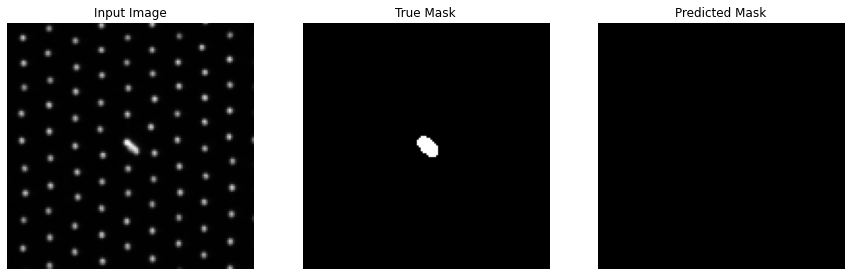

2022-03-25 16:42:23,711:root:INFO - -----END INFERENCE-----


In [49]:
if __name__ == "__main__":
    train_obj = TrainSKInterface()
    #train_obj.run_workflow(True, 0)
    train_obj.run_inference(14)